### Pregled nekaterih funkcij sagea in neka osnovna ideja formul za resolving set

In [1]:
k5 = graphs.CycleGraph(5)

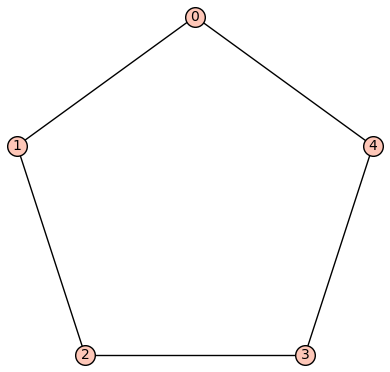

In [2]:
k5.show()

In [3]:
k5.distance_matrix() # najkrajše poti med vozlišči

[0 1 2 2 1]
[1 0 1 2 2]
[2 1 0 1 2]
[2 2 1 0 1]
[1 2 2 1 0]

In [4]:
def ali_weak_k_resolving_set(G, S, k):
    dist = G.distance_matrix() # izračunamo matriko razdalj z vgrajeno funkcijo
    vertices = G.vertices()
    n = len(vertices)
    # gremo čez vse pare vozlišč
    for a in range(n):
        for b in range(n):
            if a != b:
                vsota = sum(abs(dist[a,i]-dist[b,i]) for i in S)
                if vsota < k:
                    return False
    return True

In [5]:
# v veliko pomoč: https://doc.sagemath.org/pdf/en/reference/graphs/graphs.pdf

Okej, spodej je dejanska koda, ki se mi zdi, da bi mogla bit okej? Nevem pa kok je ekonomična + ni zares CLP??

In [6]:
from itertools import combinations

def poisci_weak_k_resolving_set(G, k):
    vertices = G.vertices()
    n = len(vertices)
    for v in range(1, n + 1):
        for komb in combinations(range(n), v):
            if ali_weak_k_resolving_set(G, komb, k):
                return [vertices[i] for i in komb], v
    return [], 0 

In [ ]:
# malo za hec, testirala kaj kej dobim z zgornjo kodo

G = graphs.CycleGraph(5)
k = 4   # tukej za 1 zamaknjeno od spodaj??
resolvent_set, wdim_k = poisci_weak_k_resolving_set(G, k)
print(f"Najmanjša šibka k-resolventna množica: {resolvent_set}")
print(f"wdim_k(G): {wdim_k}")

Najmanjša šibka k-resolventna množica: [0, 1, 2, 3, 4]
wdim_k(G): 5


In [8]:
# poiščimo \kappa''(G)
def poisci_kappa_2crti(G):
    k = 1
    while True:
        resolvent_set, size = poisci_weak_k_resolving_set(G, k)
        if not resolvent_set:  # če vrne prazno množico, končamo
            break
        k += 1
    return k - 1

In [9]:
def poisci_wmdim_k(G, k):
    resolvent_set, size = poisci_weak_k_resolving_set(G, k)
    return size if resolvent_set else None

In [10]:
# še en eksperiment, ki se ujema z zgornjo kodo 

print(f'{poisci_kappa_2crti(G)}, {poisci_wmdim_k(G, k)}')

4, 5


# CLP
Če probamo napisat še CLP za to isto stvar (again - eksperiment).
Probala si bom pomagat z https://doc.sagemath.org/html/en/reference/numerical/sage/numerical/mip.html in https://arxiv.org/abs/2309.00922

In [11]:
from sage.numerical.mip import MixedIntegerLinearProgram

def CLP_weak_k_dim(G, k):
    p = MixedIntegerLinearProgram(maximization=False)
    x = p.new_variable(binary=True)

    V = G.vertices()
    n = len(V)

    p.set_objective(sum(x[i] for i in range(n)))

    for a in range(n):
        for b in range(a + 1, n):
            p.add_constraint(
                sum(abs(G.distance(V[a], V[i]) - G.distance(V[b], V[i])) * x[i] for i in range(n)) >= k
            )
            
    wmdim_k = p.solve()
    mnozica_S = [V[i] for i in range(n) if p.get_values(x[i]) > 0.5]

    return (wmdim_k, mnozica_S)


In [12]:
G = graphs.CycleGraph(20)
G = graphs.CompleteGraph(4)
k = 1

print(f'{CLP_weak_k_dim(G,k)}')

(3.0, [0, 1, 3])


In [13]:
def kappa_2_crti(G):
    k = 1
    while True:
        try:
            CLP_weak_k_dim(G, k)
            k += 1
        except:
            return k - 1

In [14]:
G = graphs.CycleGraph(7)

H = graphs.CompleteGraph(4)
k = 1

I = graphs.CompleteBipartiteGraph(2,5)

# ostale oblike grafov so na https://doc.sagemath.org/html/en/reference/graphs/sage/graphs/graph_generators.html

# predlog: najprej probej za k = 1, da dobiš kappa'', in potem izbiraj poljuben 0 <= k<= kappa''
print(f'{CLP_weak_k_dim(G,k)}')
print(f'{kappa_2_crti(G)}')

(2.0, [2, 6])
6


# Poskus ugibanja formule
## Za cikle
Od tu naprej se začenja poskus ugibanja formule.

In [15]:
def cikli_do_n(n):
    for i in range(3, n + 1):
        G = graphs.CycleGraph(i)
        kappa_2crti = kappa_2_crti(G)
        print(f"- velikost: {i} : kappa = {kappa_2crti}")
        for k in range(kappa_2crti):
            wmdim, _ = CLP_weak_k_dim(G, k)
            print(f"  k = {k}, wmdim = {wmdim}")


In [16]:
cikli_do_n(20) 

- velikost: 3 : kappa = 2
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
- velikost: 4 : kappa = 4
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
  k = 2, wmdim = 2.0
  k = 3, wmdim = 4.0
- velikost: 5 : kappa = 4
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
  k = 2, wmdim = 3.0
  k = 3, wmdim = 4.0
- velikost: 6 : kappa = 6
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
  k = 2, wmdim = 2.0
  k = 3, wmdim = 3.0
  k = 4, wmdim = 4.0
  k = 5, wmdim = 5.0
- velikost: 7 : kappa = 6
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
  k = 2, wmdim = 3.0
  k = 3, wmdim = 4.0
  k = 4, wmdim = 5.0
  k = 5, wmdim = 6.0
- velikost: 8 : kappa = 8
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
  k = 2, wmdim = 2.0
  k = 3, wmdim = 3.0
  k = 4, wmdim = 4.0
  k = 5, wmdim = 5.0
  k = 6, wmdim = 6.0
  k = 7, wmdim = 7.0
- velikost: 9 : kappa = 8
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
  k = 2, wmdim = 3.0
  k = 3, wmdim = 4.0
  k = 4, wmdim = 5.0
  k = 5, wmdim = 6.0
  k = 6, wmdim = 7.0
  k = 7, wmdim = 8.0
- velikost: 10 : kap

Na podlagi zgornje funkcije za prvih 20 ciklov bi sklepala, da je $\kappa''(C_n) = \begin{cases}
n - 1, & \text{če je } n \text{ liho,} \\
n, & \text{če je } n \text{ sodo.}
\end{cases}$

Prav tako bi sklepala na $wmdim_k(C_n)$. Za sode $n$ (glede na zgornje rezultate) je $wmdim_k(G) = k$, za lihe pa (ko $k>0$) $wmdim_k(G) = k + 1$.

## Za hiperkocke

In [17]:
H = graphs.CubeGraph(4)

H.show3d()

Graphics3d Object

In [18]:
def hiperkocke_do_n(n):
    for i in range(1, n + 1):
        G = graphs.CubeGraph(i)
        kappa_2crti = kappa_2_crti(G)
        print(f"- velikost: {i} : kappa = {kappa_2crti}")
        for k in range(kappa_2crti):
            wmdim, _ = CLP_weak_k_dim(G, k)
            print(f"  k = {k}, wmdim = {wmdim}")

In [19]:
# tole pa nevem, če bo šlo tko. Če prou razumem, ma hiperkocka(n) 2^n vozlišč, kar zelo hitro rata zelo veliko

hiperkocke_do_n(4)

# kappa_2_crti(graphs.CubeGraph(5)) - po 14min sem obupala.

- velikost: 1 : kappa = 2
  k = 0, wmdim = 0.0
  k = 1, wmdim = 1.0
- velikost: 2 : kappa = 4
  k = 0, wmdim = 0.0
  k = 1, wmdim = 2.0
  k = 2, wmdim = 2.0
  k = 3, wmdim = 4.0
- velikost: 3 : kappa = 8
  k = 0, wmdim = 0.0
  k = 1, wmdim = 3.0
  k = 2, wmdim = 3.0
  k = 3, wmdim = 4.0
  k = 4, wmdim = 4.0
  k = 5, wmdim = 7.0
  k = 6, wmdim = 7.0
  k = 7, wmdim = 8.0
- velikost: 4 : kappa = 16
  k = 0, wmdim = 0.0
  k = 1, wmdim = 4.0
  k = 2, wmdim = 4.0
  k = 3, wmdim = 4.0
  k = 4, wmdim = 4.0
  k = 5, wmdim = 7.0
  k = 6, wmdim = 7.0
  k = 7, wmdim = 8.0
  k = 8, wmdim = 8.0
  k = 9, wmdim = 11.0
  k = 10, wmdim = 11.0
  k = 11, wmdim = 12.0
  k = 12, wmdim = 12.0
  k = 13, wmdim = 15.0
  k = 14, wmdim = 15.0
  k = 15, wmdim = 16.0


Za prvih nekaj grafov zgleda, kot, da bo formula $\kappa''(G) = 2^n$, kjer je $n$ dimenzija hiperkocke. Na podlagi rezultatov na $wmdim_k(G)$ v odvisnosti od $k$ ne znam še sklepati.